# Load Data using ``numpy`` or ``astropy``

Made by **Yoonsoo P. Bach** (Seoul National University)

In [1]:
# Made by **Yoonsoo P. Bach** (Seoul National University)
import datetime
print('Last Updated: {} KST (GMT+0900)'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

Last Updated: 2017-07-22 23:55:15 KST (GMT+0900)


This note is motivated by the fact that many people are struggling with loading data set using python. Unlike C, it's much simpler, but different from R or IDL, which are familiar to many astronomers. In this note, I will demonstrate how to load the following data table **saved in csv format** and utilize it:

image captured from LibreOffice Calc


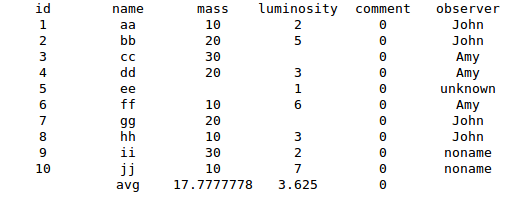

In [2]:
from IPython.display import Image
print('image captured from LibreOffice Calc')
Image("img/sample_data.png", width=500)

Our goals are:

* Import data using [``numpy.loadtxt``](https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html) or [``numpy.genfromtxt``](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html) first. 
* Save specific row/column as a variable
* Convert types (string to integer or float, etc)
* See these sometimes not work as convenient as we expect. 
* Then try [``astropy.table.Table``](http://docs.astropy.org/en/stable/table/).

There are many possibilities to import this table.

1. import all the data values including integer, string, float, etc, at once.
2. import all but ignore the header (column names) and/or footer
3. import the rows only with full data (one blank = reject)
4. import only the "id", "mass", and "luminosity" (since all these are just floats)
5. import IRAF-format table

.....

I will demonstrate all these.

In [3]:
import numpy as np
from astropy.table import Table, QTable
from astropy import units as u
from astropy import constants as c
fileloc = "data/sample_data.csv"

Since the data are comma-seperated, we have to specify ``delimeter=','`` all the time. Although this may look redundant, *python has philosophy to state as explicit as possible* (e.g., [Zen of Python](https://en.wikipedia.org/wiki/Zen_of_Python)). 

## Import Using ``numpy.loadtxt``

In [4]:
data = np.loadtxt(fileloc, delimiter=',', dtype=bytes).astype(str)
data_comment_float = data[1:, 4].astype(float)
print(data)
print('\nThe following is the comment data converted to float type')
print(data_comment_float)

[['id' 'name' 'mass' 'luminosity' 'comment' 'observer']
 ['1' 'aa' '10' '2' '0' 'John']
 ['2' 'bb' '20' '5' '0' 'John']
 ['3' 'cc' '30' '' '0' 'Amy']
 ['4' 'dd' '20' '3' '0' 'Amy']
 ['5' 'ee' '' '1' '0' 'unknown']
 ['6' 'ff' '10' '6' '0' 'Amy']
 ['7' 'gg' '20' '' '0' 'John']
 ['8' 'hh' '10' '3' '0' 'John']
 ['9' 'ii' '30' '2' '0' 'noname']
 ['10' 'jj' '10' '7' '0' 'noname']
 ['' 'avg' '17.7777777778' '3.625' '0' '']]

The following is the comment data converted to float type
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


You can see that the data table is loaded as expected. You may wonder why we need ``dtype=bytes`` and ``.astype(str)``. Basically because python 3 loads all data as ``bytes`` type, not ``str`` type. In python 2, it loaded things in ``str``, and there was no type called ``bytes``. But due to certain reasons, python 3 requires more explicit settings.

> Why python 3 is different from 2? See section "why" of [python 3 statements](http://www.python3statement.org/), especially [why python 3 exists](https://snarky.ca/why-python-3-exists/), and the presentation slide 50-53 of [Aaron Meurer](www.asmeurer.com/python3-presentation/slides.html) for examples of python 2 problems. There will be no such dramatic change to python in the future, as explained in [Nick Coghlan's posting](http://www.curiousefficiency.org/posts/2014/08/python-4000.html).

**In short, memorize ``np.loadtxt( ~~~~ , dtype=bytes).astype(str) `` as an idiom!**

If you want to convert mass column into float: 

```python
data_mass_float = data[:, 2].astype(float)
```
you will see an **error**. There are two reasons: (1) row 0 is string (``"mass"``) and (2) row 5 is size zero string (``""``). First one can be circumvented using ``skiprows`` option (see below), but second is not possible. For this reason, it is not very desirable to use ``numpy.loadtxt`` when there are blank data and/or there are header/footers.

Before moving to ``numpy.genfromtxt`` which clearly alleviates this problem, let me summarize some other functionalities in ``numpy.loadtxt``:

* If you want to use only the third/fourth (python index 2, 3) columns:
```python
data = np.loadtxt(fileloc, delimiter=',', usecols=(2, 3), dtype=bytes).astype(str)
```
* If you want to load the same columns with skipping the first row (one row):
```python
data = np.loadtxt(fileloc, delimiter=',', usecols=(2, 3), skiprows=1, dtype=bytes).astype(str)
```
* If you want to load the last column directly as float:
```python
data = np.loadtxt(fileloc, delimiter=',', usecols=(4), skiprows=1, dtype=float)
```
* If you want to declare variable faster:
```python
ids, comment = np.loadtxt(fileloc, delimiter=',', skiprows=1, usecols=(0,4), dtype=bytes, unpack=True).astype(str)
```


## Import Using ``numpy.genfromtxt``

``genfromtxt`` has few more convenient options such as 

* ``missing_values``: e.g., I want to regard ``observer=="unknown"`` as missing data points, then set this to ``"unknown"``
* ``filling_vales``: change empty cell value
* ``usemask``: For the above two to work correctly, set this to ``True``. The output will be ``numpy.ma`` (masked array).
* ``skip_header`` and ``skip_footer``: number of header/footer rows to ignore

You may realized that this is quite difficult as a front-end user to utilize all these functionalities. I first will demonstrate how to use this, and then move to ``astropy.table.Table``.

In [5]:
data = np.genfromtxt(fileloc, delimiter=',', 
                     skip_header=1,
                     missing_values="unknown",
                     filling_values=-999,
                     dtype=bytes, 
                     usemask=True).astype(str)
print("data only:")
print(data.data) # the real data part of masked array
print("masking:")
print(data.mask) # the masking part of masked array

data only:
[['1' 'aa' '10' '2' '0' 'John']
 ['2' 'bb' '20' '5' '0' 'John']
 ['3' 'cc' '30' '' '0' 'Amy']
 ['4' 'dd' '20' '3' '0' 'Amy']
 ['5' 'ee' '' '1' '0' 'unknown']
 ['6' 'ff' '10' '6' '0' 'Amy']
 ['7' 'gg' '20' '' '0' 'John']
 ['8' 'hh' '10' '3' '0' 'John']
 ['9' 'ii' '30' '2' '0' 'noname']
 ['10' 'jj' '10' '7' '0' 'noname']
 ['' 'avg' '17.7777777778' '3.625' '0' '']]
masking:
[[False False False False False False]
 [False False False False False False]
 [False False False  True False False]
 [False False False False False False]
 [False False  True False False  True]
 [False False False False False False]
 [False False False  True False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [ True False False False False  True]]


You can see that blanked cells as well as the ``missing_values`` cell (cell with ``"unknown"``) are indicated as ``--`` (masked). These masked region corresponds to the cells where ``data.mask == True``.

If you do not use ``usemask`` option, you will see nothing changes.

## Using ``astropy.table.Table``

If data contains complicated datatypes (string, float, integer, boolean, ...) with combination of different units, it is quite bothersome to utilize ``numpy``. Astropy has already made a convenient module (astropy table). It can do

* Pretty printings
* Print the table in LATEX format
* Read IRAF or DAOFIND format table
* Attribute units to columns (e.g., 10^14 M_sun, 10^3 AU, arcsec/yr, etc)
* Easy stacking

....

Astropy table has two forms: ``Table`` and ``QTable``. Slight difference between ``Table`` and ``QTable`` is given [here](http://docs.astropy.org/en/stable/table/mixin_columns.html#quantity-and-qtable):

> The only difference between QTable and Table is the behavior when adding a column that has a specified unit.

Since I also want to demonstrate table columns with units, I will use ``QTable``.

There are also few rules we have to keep in mind:

* Row should be "each target" (object 1, object 2, ...)
* Column should be "each characteristic" (mass, luminosity, ...)
* There should be no blanks

In our case, the third rule has broke down; still we can deal with the data, since these are rules, not laws.

Loading the data using ``genfromtxt`` and make a ``QTable`` object:

In [6]:
fileloc = "data/sample_data.csv"
data = np.genfromtxt(fileloc, 
                     delimiter=',',
                     skip_footer=1,
                     missing_values="unknown",
                     usemask=True, 
                     dtype=bytes).astype(str)

tab = QTable(masked=True)                   # initialize

# Instead of assigning each column, let me use a for loop:
colname = data.data[0, :]                   # extract column names
N_cols  = np.shape(colname)[0]              # number of columns
dtypes = [int, str, float, float, str, str] # which datatype you wanna use for each column

for i in range(N_cols):
    tab[colname[i]] = np.ma.filled(data[1:, i],
                                   fill_value = np.NaN).astype(dtypes[i]) 

tab.mask = QTable(data.mask[1:, :])          # set mask same as that of ``data``    

# Set units of columns
tab['mass'] *= 1.e14 * c.M_sun
tab['mass'].unit = u.kg  
tab['luminosity'].unit = u.Jy

# Print results
print(tab)
print('='*80)
print(tab.info)
print('='*80)
print('convert luminosity to SI unit:')
print()
print(tab['luminosity'].to(u.W/u.m**2/u.Hz))
print('='*80)
print('convert mass to energy unit (E = mc^2):')
print( (tab['mass'] * c.c**2).to(u.J) )


 id name          mass          luminosity comment observer
                   kg               Jy                     
--- ---- ---------------------- ---------- ------- --------
  1   aa 1.9884754153381437e+45        2.0       0     John
  2   bb 3.9769508306762875e+45        5.0       0     John
  3   cc  5.965426246014432e+45        nan       0      Amy
  4   dd 3.9769508306762875e+45        3.0       0      Amy
  5   ee                    nan        1.0       0       --
  6   ff 1.9884754153381437e+45        6.0       0      Amy
  7   gg 3.9769508306762875e+45        nan       0     John
  8   hh 1.9884754153381437e+45        3.0       0     John
  9   ii  5.965426246014432e+45        2.0       0   noname
 10   jj 1.9884754153381437e+45        7.0       0   noname
<QTable masked=True length=10>
   name     dtype  unit    class     n_bad
---------- ------- ---- ------------ -----
        id   int64      MaskedColumn     0
      name   str10      MaskedColumn     0
      mass float6

FYI, ``np.NaN`` is regarded as ``float``, so you can do usual arithmetics with ``NaN`` without any problems.

I also assigned units for two columns using ``astropy.constants`` and ``astropy.units``. Then for the luminosity, I demonstrated how to change unit to an equivalent unit. For mass, I converted kg to J by using $E = mc^2$.

Try ``print(tab.info('stats'))`` by yourself to see what comes out.

### More on Astropy Table

I want to demonstrate few more features of astropy table.


In [7]:
# Grouping

tab_T = Table(tab)
tab_T['observer'][4] = "unknown"  
# revert unknown, since ``group_by`` does not work with mask
tab_T_sort = tab_T.group_by('observer')

print(tab_T_sort)
print(tab_T_sort.groups.keys)
print(tab_T_sort.groups.indices)

 id name        mass       luminosity comment observer
                 kg            Jy                     
--- ---- ----------------- ---------- ------- --------
  3   cc 5.96542624601e+45        nan       0      Amy
  4   dd 3.97695083068e+45        3.0       0      Amy
  6   ff 1.98847541534e+45        6.0       0      Amy
  1   aa 1.98847541534e+45        2.0       0     John
  2   bb 3.97695083068e+45        5.0       0     John
  7   gg 3.97695083068e+45        nan       0     John
  8   hh 1.98847541534e+45        3.0       0     John
  9   ii 5.96542624601e+45        2.0       0   noname
 10   jj 1.98847541534e+45        7.0       0   noname
  5   ee               nan        1.0       0  unknown
observer
--------
     Amy
    John
  noname
 unknown
[ 0  3  7  9 10]


The results can be understood as (see [astropy table document](http://docs.astropy.org/en/stable/table/operations.html#table-groups) too):

```
id name    mass    luminosity comment observer
             kg         Jy                     
--- ---- ---------- ---------- ------- --------
  3   cc 5.9673e+45        nan       0      Amy  <--- start (~.groups.index = 0)
  4   dd 3.9782e+45        3.0       0      Amy
  6   ff 1.9891e+45        6.0       0      Amy
  1   aa 1.9891e+45        2.0       0     John  <--- Change group (~.groups.index = 3)
  2   bb 3.9782e+45        5.0       0     John
  7   gg 3.9782e+45        nan       0     John
  8   hh 1.9891e+45        3.0       0     John
  9   ii 5.9673e+45        2.0       0   noname  <--- Change group (~.groups.index = 7)
 10   jj 1.9891e+45        7.0       0   noname
  5   ee        nan        1.0       0  unknown  <--- Change group (~.groups.index = 9)
                                                 <--- End of data (~.groups.index = 10)
  
```

In [10]:
# Fancy output
tab.show_in_notebook()
# If you run it on your pc by yourself, you can see "search" tools, too.

idx,id,name,mass,luminosity,comment,observer
,,,kg,Jy,,
0,1,aa,1.9884754153381437e+45,2.0,0,John
1,2,bb,3.9769508306762875e+45,5.0,0,John
2,3,cc,5.965426246014432e+45,nan,0,Amy
3,4,dd,3.9769508306762875e+45,3.0,0,Amy
4,5,ee,nan,1.0,0,--
5,6,ff,1.9884754153381437e+45,6.0,0,Amy
6,7,gg,3.9769508306762875e+45,nan,0,John
7,8,hh,1.9884754153381437e+45,3.0,0,John
8,9,ii,5.965426246014432e+45,2.0,0,noname


In [9]:
# write in LATEX format
tab_T.write('data/sample_data.tex', format='latex', overwrite=True)

You may have obtained the following tex file:

``` latex
\begin{table}
\begin{tabular}{cccccc}
id & name & mass & luminosity & comment & observer \\
 &  & $\mathrm{kg}$ & $\mathrm{Jy}$ &  &  \\
1 & aa & 1.9891e+45 & 2.0 & 0 & John \\
2 & bb & 3.9782e+45 & 5.0 & 0 & John \\
3 & cc & 5.9673e+45 & nan & 0 & Amy \\
4 & dd & 3.9782e+45 & 3.0 & 0 & Amy \\
5 & ee & nan & 1.0 & 0 &  \\
6 & ff & 1.9891e+45 & 6.0 & 0 & Amy \\
7 & gg & 3.9782e+45 & nan & 0 & John \\
8 & hh & 1.9891e+45 & 3.0 & 0 & John \\
9 & ii & 5.9673e+45 & 2.0 & 0 & noname \\
10 & jj & 1.9891e+45 & 7.0 & 0 & noname \\
\end{tabular}
\end{table}
```

If you don't like ``5.9673e+45``, for example, and use ``%5.3f`` format in $10^{14}M_{\odot}$ unit, you can tune ``format`` of column:

```python
tab_T['mass'].format = '{:5.3f}' # new python 3 format style.
# identical to tab_T['mass'].format = "%5.3f"
tab_T.write('data/sample_data.tex', format='latex', overwrite=True)
```

AASTeX deluxetable format is also supported:
```python
tab_T.write('data/sample_data.tex', format='aastex', overwrite=True)
```